In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

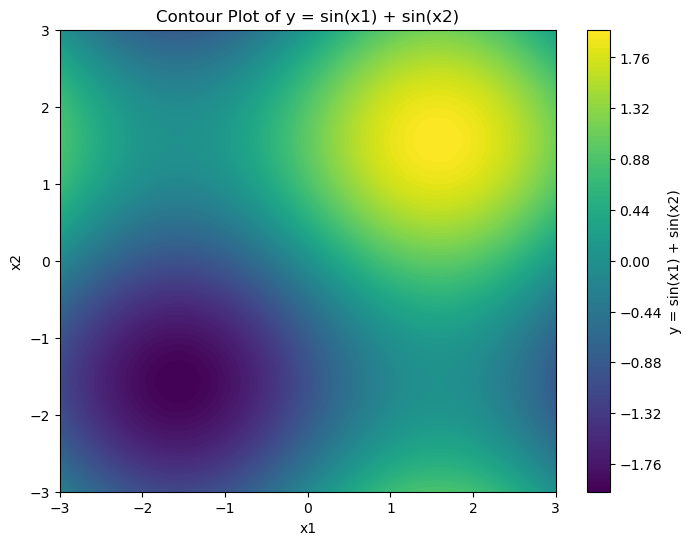

In [2]:
def generate_data(n_samples=5000):
    x1 = np.random.uniform(-3, 3, n_samples)
    x2 = np.random.uniform(-3, 3, n_samples)
    y = np.sin(x1) + np.sin(x2)
    data = np.vstack((x1, x2)).T
    return data, y

data, y = generate_data()
data[:5], y[:5]  # Display first 5 data points and their corresponding y values

# Create a grid of x1 and x2 values
x1_grid = np.linspace(-3, 3, 1000)
x2_grid = np.linspace(-3, 3, 1000)
X1, X2 = np.meshgrid(x1_grid, x2_grid)
Y = np.sin(X1) + np.sin(X2)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, Y, levels=100, cmap='viridis')
plt.colorbar(contour, label='y = sin(x1) + sin(x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of y = sin(x1) + sin(x2)')
plt.show()

In [3]:
# Prepares a single layer NN

class SingleLayerNN(nn.Module):
    def __init__(self, activation_fn):
        super(SingleLayerNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
        self.activation_fn = activation_fn
    
    def forward(self, x):
        x = self.activation_fn(self.fc1(x))
        x = self.fc2(x)
        return x

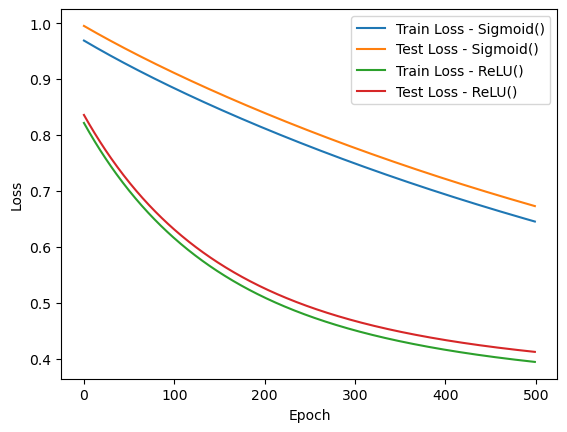

In [4]:
def train_model(activation_fn, X_train, y_train, X_test, y_test, epochs=500): # take more epochs for better performance
    model = SingleLayerNN(activation_fn)
    optimizer = optim.SGD(model.parameters(), lr=0.001) # Stochastic gradient descent
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = loss_fn(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss_fn(test_outputs, y_test)
            test_losses.append(test_loss.item())
    
    return model, train_losses, test_losses

# Convert data to torch tensors
data_tensor = torch.Tensor(data)
y_tensor = torch.Tensor(y).view(-1, 1)

# Make an 80:20 train-test split
X_train, X_test, y_train, y_test = train_test_split(data_tensor, y_tensor, test_size=0.2, random_state=42)

activations = [nn.Sigmoid(), nn.ReLU()]  # testing only with these two

models = {}
train_loss_dict = {}
test_loss_dict = {}

for activation in activations:
    model, train_losses, test_losses = train_model(activation, X_train, y_train, X_test, y_test)
    models[activation] = model
    train_loss_dict[activation] = train_losses
    test_loss_dict[activation] = test_losses

# Plot the training and test losses
for activation in activations:
    plt.plot(train_loss_dict[activation], label=f'Train Loss - {activation}')
    plt.plot(test_loss_dict[activation], label=f'Test Loss - {activation}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

It is very clear the ReLU is a better activation function and hence I'll proceed with that.

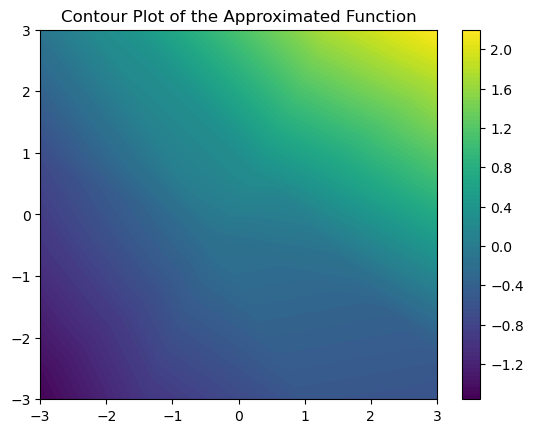

In [5]:
best_model = models[activations[1]]  # ReLU performs better!

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
x1, x2 = np.meshgrid(x1, x2)
input_data = np.vstack([x1.ravel(), x2.ravel()]).T

input_tensor = torch.Tensor(input_data)
with torch.no_grad():
    output = best_model(input_tensor)

output = output.view(x1.shape).numpy()

plt.contourf(x1, x2, output, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Contour Plot of the Approximated Function')
plt.show()

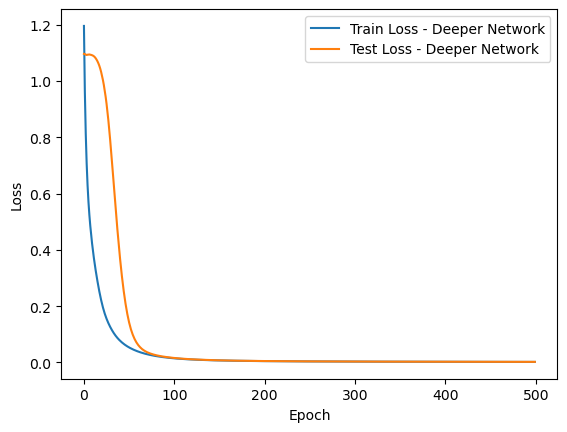

In [6]:
# Increasing the width and depth of the neural network and see how it improves the performance
class DeeperNN(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(DeeperNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),            # Wider first layer
            nn.BatchNorm1d(128),
            activation_fn,
            nn.Linear(128, 128),          # Wide hidden layers
            nn.BatchNorm1d(128),
            activation_fn,
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            activation_fn,
            nn.Linear(128, 64),           # Gradually reduce width
            nn.BatchNorm1d(64),
            activation_fn,
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            activation_fn,
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            activation_fn,
            nn.Linear(32, 1)              # Output layer
        )

    def forward(self, x):
        return self.net(x)

def train_deeper_model(activation_fn, X_train, y_train, X_test, y_test, epochs=500):
    model = DeeperNN(activation_fn)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        train_loss = loss_fn(outputs, y_train)
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = loss_fn(test_outputs, y_test)
            test_losses.append(test_loss.item())
    
    return model, train_losses, test_losses

deeper_model, deeper_train_losses, deeper_test_losses = train_deeper_model(nn.ReLU(), X_train, y_train, X_test, y_test)

plt.plot(deeper_train_losses, label='Train Loss - Deeper Network')
plt.plot(deeper_test_losses, label='Test Loss - Deeper Network')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

At least in this model, the contour plot of the approximated function, though has qualitative features, does not quantitatively resemble the original contour plot of the target function.

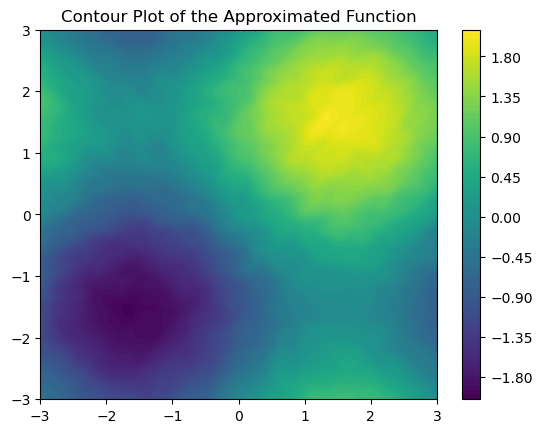

In [7]:
best_model = models[activations[1]]  # ReLU performs better!

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
x1, x2 = np.meshgrid(x1, x2)
input_data = np.vstack([x1.ravel(), x2.ravel()]).T

input_tensor = torch.Tensor(input_data)
with torch.no_grad():
    output = deeper_model(input_tensor)

output = output.view(x1.shape).numpy()

plt.contourf(x1, x2, output, levels=100, cmap='viridis')
plt.colorbar()
plt.title('Contour Plot of the Approximated Function')
plt.show()

As is evident, the deeper model (with more layers, and more number of neurons per layer, with the same ReLU activation function, performs much better! The new contour plot is a near perfect approximation of the original trigonometric function.